In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import pyvista as pv
import numpy as np
import sionna
import tensorflow as tf
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver, Camera

no_preview = False # Toggle to False to use the preview widget

mi.set_variant("llvm_ad_mono_polarized")

scene_path = r"/Users/shreeya/Documents/GitHub/ECE257A_Project/scene/scene_01.xml"

Matplotlib is building the font cache; this may take a moment.


ImportError: Encountered an error while initializing the extension.

In [4]:
# Load scene with Sionna for ray tracing capabilities
print("Loading scene with Sionna...")
scene = load_scene(scene_path)
print("Sionna scene loaded.")

Loading scene with Sionna...
Sionna scene loaded.


In [5]:

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Fixed transmitter and receiver positions
tx_position = np.array([-2.0, 0.5, 0])   # [x, y, z]
rx_position = np.array([1.0, 1.1, 2.8])   # [x, y, z]

print(f"Transmitter position: {tx_position}")
print(f"Receiver position: {rx_position}")

# Create transmitter and receiver
tx = Transmitter(name="tx",
                 position=tx_position,
                 display_radius=0.01)

rx = Receiver(name="rx",
              position=rx_position,
              display_radius=0.01)

# Add to scene
scene.add(tx)
scene.add(rx)

# Make transmitter point towards receiver
tx.look_at(rx)

Transmitter position: [-2.   0.5  0. ]
Receiver position: [1.  1.1 2.8]


Computing paths...


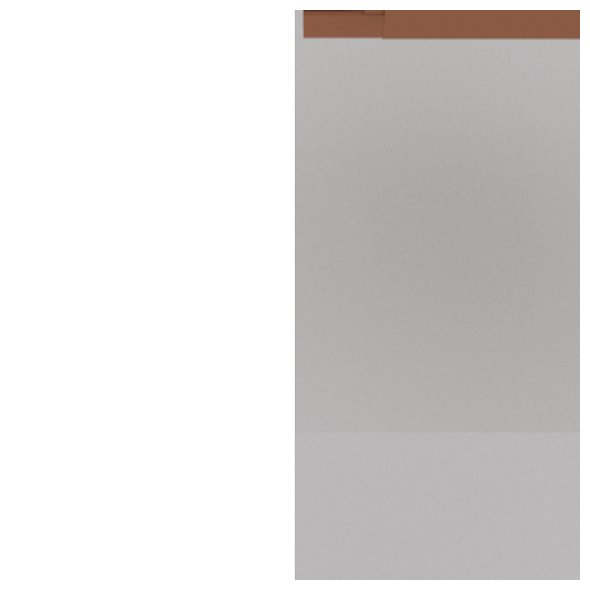

In [6]:
# Instantiate a path solver
p_solver = PathSolver()

# Compute propagation paths - using ONLY the required parameter
print("Computing paths...")
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

# Create new camera with different configuration
my_cam = Camera(position=[3.0,0.0,3.0], look_at=[0,0,0])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[400, 400], num_samples=512); # Increase num_samples to increase image quality

if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

In [7]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

Shape of a:  (1, 2, 1, 1, 13, 1)
Shape of tau:  (1, 2, 1, 1, 13)


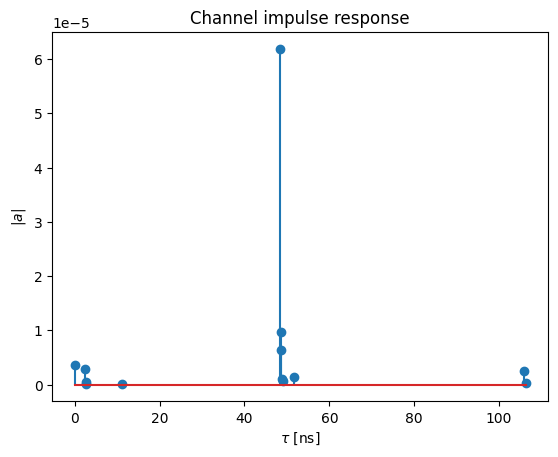

In [8]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
# Visualize with PyVista
plotter = pv.Plotter(notebook=False)

# Add scene geometry from Mitsuba
mi_scene = mi.load_file(scene_path)
for shape in mi_scene.shapes():
    params = mi.traverse(shape)
    vertices = np.array(params["vertex_positions"], dtype=np.float32).reshape(-1, 3)
    faces = np.array(params["faces"], dtype=np.int32).reshape(-1, 3)
    
    faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).flatten()
    pv_mesh = pv.PolyData(vertices, faces_pv)
    plotter.add_mesh(pv_mesh, color="lightgray", show_edges=True, opacity=0.7)

# Add transmitter and receiver as spheres
tx_sphere = pv.Sphere(radius=0.1, center=tx_position)
rx_sphere = pv.Sphere(radius=0.1, center=rx_position)
plotter.add_mesh(tx_sphere, color="red", label="Transmitter")
plotter.add_mesh(rx_sphere, color="green", label="Receiver")
# Add legend and show
plotter.add_legend()
plotter.add_axes()
plotter.add_title(f"Ray Tracing Visualization")
plotter.show()

# Additional: Show scene summary
print("\n=== Scene Summary ===")
print(f"Number of objects in scene: {len(scene.objects)}")
print(f"Transmitter orientation: {tx.orientation}")
print(f"Receiver orientation: {rx.orientation}")
print(f"Path solver settings: max_depth=5")